In [51]:
import numpy as np
import tensorflow as tf
import random as rn
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1)
rn.seed(1)
from keras import backend as K
tf.set_random_seed(1)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
import sys
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from keras.layers import Conv1D,MaxPooling1D,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TerminateOnNaN
from keras.callbacks import TensorBoard
import keras.regularizers
import scipy
import math
import sys
import pandas as pd
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress
from scipy import interpolate
from scipy import signal
#import cPickle as pickle
#from video_process_utils import *
import collections
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="0" 
import gc
from time import time
from keras.layers.wrappers import TimeDistributed
from keras.layers.pooling import GlobalAveragePooling2D

In [2]:
def ImportImage(filepath):
    #print(filepath)
    img = Image.open(filepath)
    return np.array(img)

In [98]:
#imagepaths_labels = pd.read_csv('./data/test/labels/imagepath_gdi_10.csv')
imagepaths_labels = pd.read_csv('./data/test/labels/imagepath_gdi_10.csv')
msk = np.random.rand(len(imagepaths_labels)) < 0.8
train=imagepaths_labels[msk]
validation=imagepaths_labels[~msk]

In [99]:
train_imgs = np.array([ImportImage(img) for img in train['image_path'].values])
train_labels = np.array([label for label in train['labels_norm'].values])
validation_imgs = np.array([ImportImage(img) for img in validation['image_path'].values])
validation_labels = np.array([label for label in validation['labels_norm'].values])

In [100]:
gc.collect()

4291

In [101]:
print('train images shape : ',train_imgs.shape)
print('train labels shape : ',train_labels.shape)
print('validation images shape : ',validation_imgs.shape)
print('validation labels shape : ',validation_labels.shape)

train images shape :  (3795, 480, 640, 3)
train labels shape :  (3795,)
validation images shape :  (990, 480, 640, 3)
validation labels shape :  (990,)


In [76]:
len(train['labels'].unique())

435

In [7]:
for i, image in enumerate(train_imgs):
    if (np.count_nonzero(image)<1):
        print('all zeros at : ', i)

In [8]:
for i, image in enumerate(validation_imgs):
    if (np.count_nonzero(image)<1):
        print('all zeros at : ', i)

In [102]:
def step_decay(initial_lrate,epochs_drop,drop_factor):
    def step_decay_fcn(epoch):
        return initial_lrate * math.pow(drop_factor, math.floor((1+epoch)/epochs_drop))
    return step_decay_fcn

checkpoint_folder = "./cnn_checkpoints_gdicnn"
batch_size  = 16
num_classes = len(train_labels)
epochs = 50
epochs_drop,drop_factor = (10,0.8)
input_shape = train_imgs[0].shape
kernel_size = 8
conv_dim = 16
initial_lrate = 0.001
dropout_amount = 0.5
l2_lambda = 10**(-3.5)
reg = keras.regularizers.l2(l2_lambda)
last_layer_dim=18

In [10]:
model = Sequential()
model.add(Conv2D(conv_dim, kernel_size=kernel_size, input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(conv_dim,kernel_size=kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(dropout_amount))
model.add(Conv2D(conv_dim,kernel_size=kernel_size,padding='same',kernel_regularizer=reg))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(conv_dim,kernel_size=kernel_size,padding='same',kernel_regularizer=reg))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(dropout_amount))
model.add(Conv2D(conv_dim,kernel_size=kernel_size,padding='same',kernel_regularizer=reg))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(conv_dim,kernel_size=kernel_size,padding='same',kernel_regularizer=reg))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(dropout_amount))
model.add(Flatten())
model.add(Dense(last_layer_dim,activation='relu'))
model.add(Dense(1, activation='linear'))

In [11]:
train_model = True

if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)

filepath=checkpoint_folder+"/weights-{epoch:02d}.hdf5"
if train_model:

    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = RMSprop(lr=0.0,rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss='mse',metrics=['accuracy'],optimizer=opt)
    #model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])


    checkpoint = \
        ModelCheckpoint(filepath, verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    lr = LearningRateScheduler(step_decay(initial_lrate,epochs_drop,drop_factor))
    
    tensorboard = keras.callbacks.TensorBoard(log_dir='./tensorboard-logs/linear/{}'.format(time()))

    history = model.fit(train_imgs, train_labels,callbacks=[checkpoint,lr,TerminateOnNaN(),tensorboard],
              validation_data=(validation_imgs,validation_labels),
              batch_size=batch_size, epochs=epochs,shuffle=True)

Train on 17732 samples, validate on 4453 samples
Epoch 1/50
17732/17732 [==============================] - 1465s 83ms/step - loss: 9.1405 - acc: 0.1518 - val_loss: 34.7534 - val_acc: 0.0177

Epoch 00001: val_loss improved from inf to 34.75343, saving model to ./cnn_checkpoints_gdicnn/weights-01.hdf5
Epoch 2/50
17732/17732 [==============================] - 1445s 82ms/step - loss: 4.0677 - acc: 0.2105 - val_loss: 4.2679 - val_acc: 0.1806

Epoch 00002: val_loss improved from 34.75343 to 4.26789, saving model to ./cnn_checkpoints_gdicnn/weights-02.hdf5
Epoch 3/50
17732/17732 [==============================] - 1448s 82ms/step - loss: 2.9564 - acc: 0.2449 - val_loss: 9.7547 - val_acc: 0.0638

Epoch 00003: val_loss did not improve from 4.26789
Epoch 4/50
17732/17732 [==============================] - 1443s 81ms/step - loss: 2.2506 - acc: 0.2800 - val_loss: 7.9401 - val_acc: 0.0833

Epoch 00004: val_loss did not improve from 4.26789
Epoch 5/50
17732/17732 [==============================] - 14

KeyboardInterrupt: 

In [12]:
gc.collect()

0

In [103]:
batch_size  = 18
dropout_amount = 0.5
checkpoint_folder = "./cnn_checkpoints_gdicnn_loss_dout"
reg = keras.regularizers.l2(l2_lambda)

In [104]:
from keras.utils.np_utils import to_categorical
train_categorical_labels = to_categorical(train_labels, num_classes=None)
validation_categorical_labels = to_categorical(validation_labels, num_classes=None)

In [105]:
type(train_categorical_labels)

numpy.ndarray

In [106]:
len(train_categorical_labels[0])

18

In [107]:
model = Sequential()
model.add(Conv2D(conv_dim, kernel_size=kernel_size, input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(conv_dim,kernel_size=kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(dropout_amount))
model.add(Conv2D(conv_dim,kernel_size=kernel_size,padding='same',kernel_regularizer=reg))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(conv_dim,kernel_size=kernel_size,padding='same',kernel_regularizer=reg))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(dropout_amount))
model.add(Conv2D(conv_dim,kernel_size=kernel_size,padding='same',kernel_regularizer=reg))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(conv_dim,kernel_size=kernel_size,padding='same',kernel_regularizer=reg))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(dropout_amount))
model.add(Flatten())
model.add(Dense(last_layer_dim,activation='relu'))
model.add(Dense(18, activation='softmax'))

In [108]:
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)

filepath=checkpoint_folder+"/weights-{epoch:02d}.hdf5"

opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#opt = RMSprop(lr=0.0,rho=0.9, epsilon=1e-08, decay=0.0)
#model.compile(loss=keras.losses.sparse_categorical_crossentropy,metrics=['accuracy'],optimizer=opt)
model.compile(loss=keras.losses.categorical_crossentropy,metrics=['accuracy'],optimizer=opt)
#model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])


checkpoint = \
    ModelCheckpoint(filepath, verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

lr = LearningRateScheduler(step_decay(initial_lrate,epochs_drop,drop_factor))

tensorboard = keras.callbacks.TensorBoard(log_dir='./tensorboard-logs/{}'.format(time()))

history = model.fit(train_imgs, train_categorical_labels,callbacks=[checkpoint,lr,TerminateOnNaN(),tensorboard],
          validation_data=(validation_imgs,validation_categorical_labels),
          batch_size=batch_size, epochs=epochs,shuffle=True)

Train on 3795 samples, validate on 990 samples
Epoch 1/50
3795/3795 [==============================] - 305s 80ms/step - loss: 3.0427 - acc: 0.1333 - val_loss: 3.7498 - val_acc: 0.1293

Epoch 00001: val_loss improved from inf to 3.74981, saving model to ./cnn_checkpoints_gdicnn_loss_dout/weights-01.hdf5
Epoch 2/50
3795/3795 [==============================] - 300s 79ms/step - loss: 2.7602 - acc: 0.1426 - val_loss: 2.8083 - val_acc: 0.1434

Epoch 00002: val_loss improved from 3.74981 to 2.80828, saving model to ./cnn_checkpoints_gdicnn_loss_dout/weights-02.hdf5
Epoch 3/50
3795/3795 [==============================] - 300s 79ms/step - loss: 2.6795 - acc: 0.1513 - val_loss: 2.7262 - val_acc: 0.1525

Epoch 00003: val_loss improved from 2.80828 to 2.72618, saving model to ./cnn_checkpoints_gdicnn_loss_dout/weights-03.hdf5
Epoch 4/50
3795/3795 [==============================] - 299s 79ms/step - loss: 2.6223 - acc: 0.1542 - val_loss: 2.6069 - val_acc: 0.1626

Epoch 00004: val_loss improved from 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


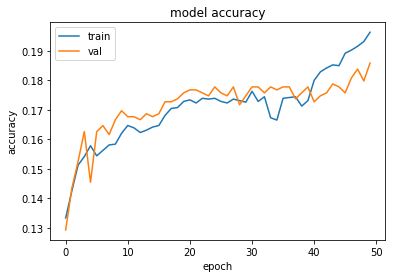

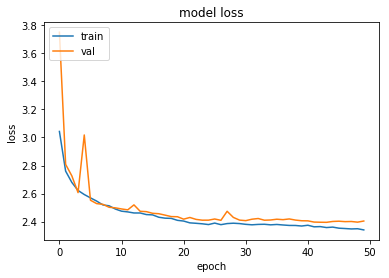

In [110]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
gc.collect()

488

In [94]:
def step_decay(initial_lrate,epochs_drop,drop_factor):
    def step_decay_fcn(epoch):
        return initial_lrate * math.pow(drop_factor, math.floor((1+epoch)/epochs_drop))
    return step_decay_fcn

checkpoint_folder = "./cnn_checkpoints_gdicnn_lstm"
batch_size  = 16
num_classes = len(train['labels'].unique())#len(train_labels)
epochs = 50
epochs_drop,drop_factor = (10,0.8)
input_shape = train_imgs[0].shape
kernel_size = 8
conv_dim = 16
initial_lrate = 0.001
dropout_amount = 0.5
l2_lambda = 10**(-3.5)
reg = keras.regularizers.l2(l2_lambda)
last_layer_dim=18

In [97]:
model = Sequential()
model.add(Conv2D(conv_dim, kernel_size=kernel_size, input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(dropout_amount))
#model.add(Flatten())
model.add(LSTM(input_shape))
model.add(Dense(1, activation='linear'))

ValueError: Input 0 is incompatible with layer lstm_15: expected ndim=3, found ndim=4

In [ ]:
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)

filepath=checkpoint_folder+"/weights-{epoch:02d}.hdf5"
#opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mse',metrics=['accuracy'],optimizer='adam')

checkpoint = \
    ModelCheckpoint(filepath, verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

lr = LearningRateScheduler(step_decay(initial_lrate,epochs_drop,drop_factor))

tensorboard = keras.callbacks.TensorBoard(log_dir='./tensorboard-logs/lstm/{}'.format(time()))

history = model.fit(train_imgs, train_labels,callbacks=[checkpoint,lr,TerminateOnNaN(),tensorboard],
          validation_data=(validation_imgs,validation_labels),
          batch_size=batch_size, epochs=epochs,shuffle=True)